In [1]:
import polars as pl # similar pandas, faster than pandas 10x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow.parquet as pq
import pyarrow as pa
from pandas.api.types import CategoricalDtype
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

# 1. LOAD DATA
## Load CSV/Parquet files into Polars DataFrames
#### If Parquet exists, read it directly; otherwise read CSV, write Parquet, then read

In [2]:
# Paths
csv_dir = Path("../../data/csv")
parquet_dir = Path("../../data/parquet")
parquet_dir.mkdir(exist_ok=True)

tables = ["flights_sample_3m", 
         "airports_clean"]

dfs = {}

for table in tables:
    csv_path = csv_dir / f"{table}.csv"
    parquet_path = parquet_dir / f"{table}.parquet"

    try:
        if parquet_path.exists(): 
            print(f"{parquet_path} already exists, reading Parquet...")
        else:
            print(f"{parquet_path} not found, reading CSV and writing Parquet...")
            (pl.scan_csv(csv_path, low_memory=True).sink_parquet(parquet_path))
            print(f"{parquet_path} has been created.\n")

        # Read parquet
        df = pl.read_parquet(parquet_path)
        dfs[table] = df
        print(f"{table}: {df.shape[0]} rows, {df.shape[1]} columns\n")

    except Exception as e:
        print(f"Error reading {table}: {e}")

..\..\data\parquet\flights_sample_3m.parquet already exists, reading Parquet...
flights_sample_3m: 3000000 rows, 32 columns

..\..\data\parquet\airports_clean.parquet already exists, reading Parquet...
airports_clean: 7697 rows, 6 columns



In [3]:
df_flights = dfs["flights_sample_3m"]
df_airports = dfs["airports_clean"]

# 2. FEATURE ENGINEERING & DATA CLEANING
## 2.1 Feature Engineering
### Time & Distance Features

In [4]:
dow_category = CategoricalDtype(categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
                                            "Saturday", "Sunday"], ordered=True)

dow_map = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday",
           5: "Friday", 6: "Saturday", 7: "Sunday"}

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

if df_flights.schema["FL_DATE"] == pl.Utf8:
    df_flights = df_flights.with_columns(
        pl.col("FL_DATE").str.strptime(pl.Date)
    )
    
df_flights = df_flights.with_columns([
    pl.col("FL_DATE").dt.year().alias("YEAR"),
    pl.col("FL_DATE").dt.month().alias("MONTH"),
    (((pl.col("FL_DATE").dt.month() - 1) // 3) + 1).alias("QUARTER"),
    pl.col("FL_DATE").dt.weekday().alias("DAY_OF_WEEK"),
    pl.col("FL_DATE").dt.month().map_elements(get_season).alias("SEASON"),
    # Bọc string bằng pl.lit() để pl hiểu là giá trị, ko phải tên cột
    pl.when(pl.col("DISTANCE") <= 500).then(pl.lit("Short-haul"))
      .when(pl.col("DISTANCE") <= 1500).then(pl.lit("Medium-haul"))
      .otherwise(pl.lit("Long-haul"))
      .alias("DISTANCE_CAT")
])

### Adding Geolocation Columns

In [5]:
airports_ll = (
    df_airports
    .filter(pl.col("IATA").is_not_null() & (pl.col("IATA") != ""))
    .select(["IATA", "LAT", "LON"])
)

df_flights = (
    df_flights.join(airports_ll, left_on="ORIGIN", right_on="IATA", how="left").
    rename({"LAT": "ORIGIN_LAT", "LON": "ORIGIN_LON"}).
        join(airports_ll, left_on="DEST", right_on="IATA", how="left").
        rename({"LAT": "DEST_LAT", "LON": "DEST_LON"})
)

## 2.2 Check for missing values

In [6]:
def check_missing_cols(df):
    missing_cols = []
    no_missing_cols = []

    for col in df.columns:
        missing_count = df[col].null_count()
        if missing_count > 0:
            missing_cols.append((col, missing_count))
        else:
            no_missing_cols.append(col)

    print("Columns WITH missing values:")
    if missing_cols:
        for col, cnt in missing_cols:
            print(f"- {col}: {cnt}")
    else:
        print("None")

    print("\nColumns WITHOUT missing values:")
    print(no_missing_cols if no_missing_cols else "None")

check_missing_cols(df_flights)

Columns WITH missing values:
- DEP_TIME: 77615
- DEP_DELAY: 77644
- TAXI_OUT: 78806
- WHEELS_OFF: 78806
- WHEELS_ON: 79944
- TAXI_IN: 79944
- ARR_TIME: 79942
- ARR_DELAY: 86198
- CANCELLATION_CODE: 2920860
- CRS_ELAPSED_TIME: 14
- ELAPSED_TIME: 86198
- AIR_TIME: 86198
- DELAY_DUE_CARRIER: 2466137
- DELAY_DUE_WEATHER: 2466137
- DELAY_DUE_NAS: 2466137
- DELAY_DUE_SECURITY: 2466137
- DELAY_DUE_LATE_AIRCRAFT: 2466137
- ORIGIN_LAT: 735
- ORIGIN_LON: 735
- DEST_LAT: 762
- DEST_LON: 762

Columns WITHOUT missing values:
['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CANCELLED', 'DIVERTED', 'DISTANCE', 'YEAR', 'MONTH', 'QUARTER', 'DAY_OF_WEEK', 'SEASON', 'DISTANCE_CAT']


In [7]:
# df_flights = df_flights.drop_nulls(subset=["ORIGIN_LAT", "ORIGIN_LON", 
#                                           "DEST_LAT", "DEST_LON"])

## 2.3 Format numbers

In [8]:
def format_compact(n):
    if n >= 1_000_000:
        x = n / 1_000_000
        return f"{x:.2f}M".replace(".0M", "M")
    if n >= 1_000:
        x = n / 1_000
        return f"{x:.2f}K".replace(".0K", "K")
    return str(n)

# 3. EDA
## 3.1 Homepage
### Summary (Group_by --> Filter last year & first year)

In [9]:
def pct_vs_baseline(df, year, baseline, col):
    n_year = df.filter(pl.col("YEAR") == year)[col][0]
    n_base = df.filter(pl.col("YEAR") == baseline)[col][0]
    return round(((n_year - n_base)/n_base) * 100, 2)

def get_operated_flights(df: pl.DataFrame) -> pl.DataFrame:
    return df.filter(
        (pl.col("CANCELLED") == 0) & (pl.col("DIVERTED") == 0)
    )

def count_by_year(df, condition=None, col_name="n"):
    if condition is not None:
        df = df.filter(condition)

    return (
        df.group_by("YEAR")
          .agg(pl.len().alias(col_name))
          .sort("YEAR")
    )

def ontime_delay_by(df, group_cols):
    df_op = get_operated_flights(df)

    return (
        df_op
        .with_columns([
            (pl.col("DEP_DELAY") <= 15).cast(pl.Int64).alias("n_ontime"),
            (pl.col("DEP_DELAY") > 15).cast(pl.Int64).alias("n_delayed")
        ])
        .group_by(group_cols)
        .agg([
            pl.sum("n_ontime").alias("n_ontime"),
            pl.sum("n_delayed").alias("n_delayed"),
            pl.len().alias("n_operated"),
            pl.mean("DEP_DELAY").alias("avg_delay")
        ])
        .with_columns([
            (pl.col("n_ontime") / pl.col("n_operated") * 100).alias("pct_ontime"),
            (pl.col("n_delayed") / pl.col("n_operated") * 100).alias("pct_delayed")
        ])
        .sort(group_cols)
    )

In [10]:
flight_yearly = count_by_year(df_flights, col_name="n_flights")

df_cancel = count_by_year(
    df_flights,
    condition=pl.col("CANCELLED") == 1,
    col_name="n_cancelled"
)

df_divert = count_by_year(
    df_flights,
    condition=pl.col("DIVERTED") == 1,
    col_name="n_diverted"
)

df_operated = count_by_year(
    df_flights,
    condition=(pl.col("CANCELLED") == 0) & (pl.col("DIVERTED") == 0),
    col_name="n_operated"
)


In [11]:
df_ontime_delay = ontime_delay_by(df_flights, ["YEAR"])

pct_23_19_flight = pct_vs_baseline(flight_yearly, 2023, 2019, col="n_flights")

pct_23_19_cancel = pct_vs_baseline(df_cancel, 2023, 2019, col="n_cancelled")
pct_23_19_divert = pct_vs_baseline(df_divert, 2023, 2019, col="n_diverted")
pct_23_19_operated = pct_vs_baseline(df_operated, 2023, 2019, col="n_operated")

pct_23_19_ontime = pct_vs_baseline(df_ontime_delay, 2023, 2019, col="n_ontime")
pct_23_19_delayed = pct_vs_baseline(df_ontime_delay, 2023, 2019, col="n_delayed")

total_flights = df_flights.height
total_airlines = df_flights["AIRLINE"].n_unique()
total_airports = df_flights["ORIGIN"].n_unique()
total_routes = df_flights.select(["ORIGIN", "DEST"]).unique().height

total_flights_fmt = format_compact(total_flights)

print(f"U.S. Flight Operations: 2019–2023"
      f"\nFlights volume vs 2019: {pct_23_19_flight}%"
      f"\nCancelled vs 2019: {pct_23_19_cancel}%"
      f"\nDiverted vs 2019: {pct_23_19_divert}%"
      f"\nOperated vs 2019: {pct_23_19_operated}%"
      f"\n  - On-time vs 2019: {pct_23_19_ontime}%"
      f"\n  - Delayed vs 2019: {pct_23_19_delayed}%"
      f"\nTotal flights: {total_flights_fmt}"
      f"\nTotal airlines: {total_airlines}"
      f"\nTotal airports: {total_airports}"
      f"\nTotal routes: {total_routes}"
)

U.S. Flight Operations: 2019–2023
Flights volume vs 2019: -38.83%
Cancelled vs 2019: -42.56%
Diverted vs 2019: -36.41%
Operated vs 2019: -38.77%
  - On-time vs 2019: -41.79%
  - Delayed vs 2019: -24.99%
Total flights: 3.00M
Total airlines: 18
Total airports: 380
Total routes: 7785


### Chart: Weekly Distribution

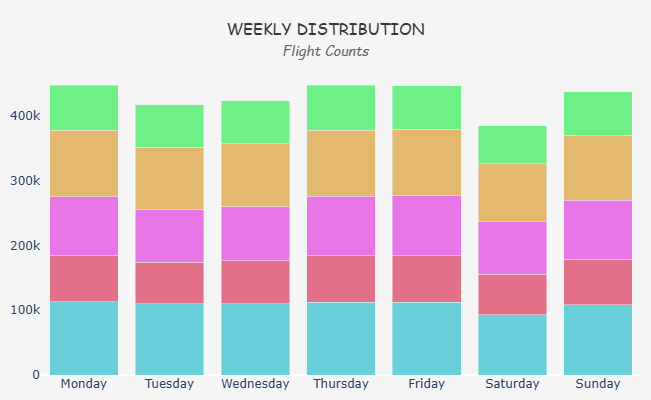

In [12]:
df_dow = (
    df_flights
    .group_by(["YEAR", "DAY_OF_WEEK"])
    .agg(pl.len().alias("n_flights"))
    .with_columns(
        # convert DAY_OF_WEEK (1–7) → Monday–Sunday
        pl.col("DAY_OF_WEEK")
        .map_elements(lambda x: dow_map.get(x), return_dtype=pl.Utf8)
        .alias("DAY"),

        # YEAR → string (Plotly views as categorical)
        pl.col("YEAR").cast(pl.Utf8)
    )
    .sort(["YEAR", "DAY_OF_WEEK"])
)

year_colors = {
    "2019": "#47c6d1", 
    "2020": "#de506f",  
    "2021": "#e657e3", 
    "2022": "#deab4e", 
    "2023": "#4df06b",
}
fig_1 = px.bar(df_dow,
            x='DAY', y='n_flights',
            color='YEAR', color_discrete_map = year_colors,
            height=400, 
            color_discrete_sequence = px.colors.qualitative.Pastel)
fig_1.update_layout(barmode="stack", showlegend = False,
                  xaxis_title = None, yaxis_title = None,
                  yaxis=dict(showgrid=False),
                  title=dict(
                    text=(
                        "WEEKLY DISTRIBUTION"
                        "<br><span style='font-size:14px;color:#666;font-style:italic'>Flight Counts</span>"
                    ),
                    x=0.5,
                    xanchor="center"
                  ),
                  margin = dict(l=10, r=10, t=70, b=10),
                  paper_bgcolor="#f5f5f5",   # nền toàn figure (kể cả title)
                  plot_bgcolor="#f5f5f5",    # nền vùng bar chart
                  title_font=dict(size=16, color="#333", family="Comic Sans MS")
)
fig_1.update_traces(opacity = 0.8)
fig_1.show()

### Chart: Airline Rankings

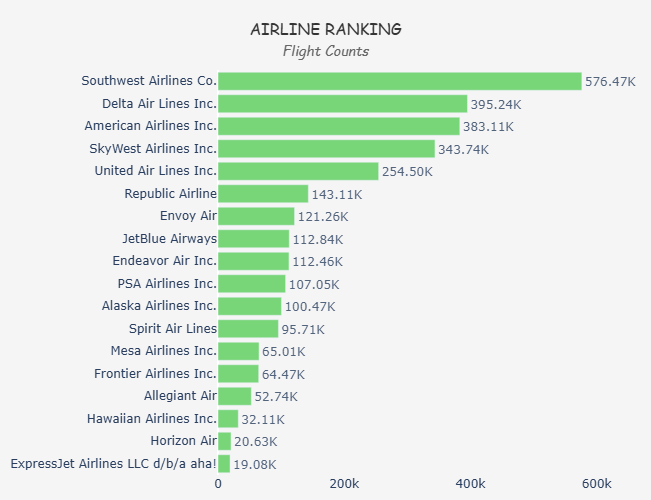

In [13]:
df_air_rank = (
    df_flights
    .group_by("AIRLINE")
    .agg(pl.len().alias("n_flights"))
    .sort("n_flights", descending=True)
).to_pandas()

df_air_rank["text"] = df_air_rank["n_flights"].apply(format_compact)

fig_2 = px.bar(
    df_air_rank,
    x="n_flights", y="AIRLINE",
    orientation="h", text="text", 
    color_discrete_sequence=["#59cf5a"]  # màu tất cả bar
)
fig_2.update_layout(yaxis_title = None, xaxis_title=None,
                  yaxis=dict(autorange="reversed"), 
                  xaxis=dict(showgrid=False),                 
                  height = 500,
                  title=dict(
                    text=(
                        "AIRLINE RANKING"
                        "<br><span style='font-size:14px;color:#666;font-style:italic'>Flight Counts</span>"
                    ),
                    x=0.5,
                    xanchor="center"
                  ),
                  margin = dict(l=200, r=50, t=70, b=10),
                  paper_bgcolor="#f5f5f5",   # nền toàn figure (kể cả title)
                  plot_bgcolor="#f5f5f5",    # nền vùng bar chart
                  title_font=dict(size=16, color="#333", family="Comic Sans MS")
)
# Hiển thị text bên ngoài bar, cliponaxis để text xuất hiện đầy đủ
fig_2.update_traces(textposition='outside', cliponaxis=False,
                 opacity = 0.8)
fig_2.show()

### Chart: Monthly Departures

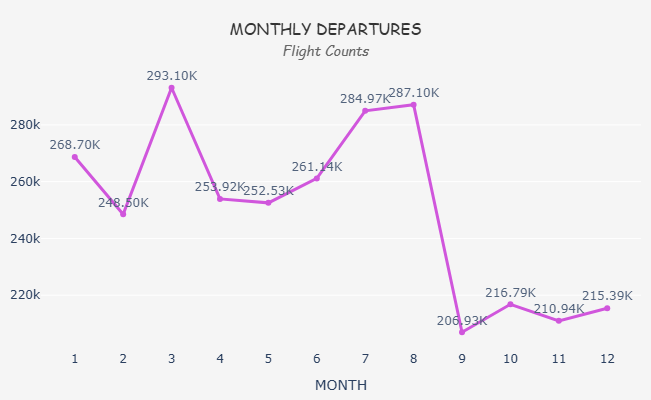

In [14]:
df_monthly_departures = (
    df_flights
    .group_by("MONTH")
    .agg(pl.len().alias("n_flights"))
    .sort("MONTH")
).to_pandas()

df_monthly_departures["text"] = df_monthly_departures["n_flights"].apply(format_compact)

fig_3 = px.line(df_monthly_departures,
              x='MONTH', y='n_flights',
              markers=True, text="text")
fig_3.update_layout(yaxis_title = None,  
                  xaxis=dict(showgrid=False), 
                  height = 400,
                  title=dict(
                    text=(
                        "MONTHLY DEPARTURES"
                        "<br><span style='font-size:14px;color:#666;font-style:italic'>Flight Counts</span>"
                    ),
                    x=0.5,
                    xanchor="center"
                  ),
                  margin = dict(l=10, r=10, t=70, b=10),
                  paper_bgcolor="#f5f5f5",   # nền toàn figure (kể cả title)
                  plot_bgcolor="#f5f5f5",    # nền vùng bar chart
                  title_font=dict(size=16, color="#333", family="Comic Sans MS")
)
fig_3.update_xaxes(type="category") # để trục x chỉ show 1 2 3 4
# Hiển thị text ra ngoài điểm marker
fig_3.update_traces(
    textposition='top center',  # hoặc 'bottom center', 'middle right', 'middle left'
    opacity = 0.8, cliponaxis=False, # cliponaxis để text xuất hiện đầy đủ
    line=dict(color="#c82fd6", width=3),
)
fig_3.show()

*Note: Data for 2023 available through August only*

### Chart: Flight Distance Distribution

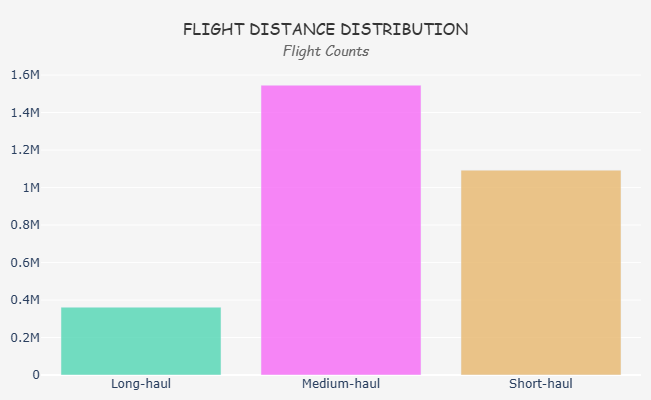

In [15]:
df_distance_departures = (
    df_flights
    .group_by("DISTANCE_CAT")
    .agg(pl.len().alias("n_flights")).sort("DISTANCE_CAT")
)

fig_4 = px.bar(df_distance_departures,
            x='DISTANCE_CAT', y='n_flights',
            color='DISTANCE_CAT', color_discrete_map = year_colors,
            height=400, 
            color_discrete_sequence = ["#f76af7", "#e8b76d", "#51d6b3"])
fig_4.update_layout(showlegend = False,
                  xaxis_title = None, yaxis_title = None,
                  title=dict(
                    text=(
                        "FLIGHT DISTANCE DISTRIBUTION"
                        "<br><span style='font-size:14px;color:#666;font-style:italic'>Flight Counts</span>"
                    ),
                    x=0.5,
                    xanchor="center"
                  ),
                  margin = dict(l=10, r=10, t=70, b=10),
                  paper_bgcolor="#f5f5f5",   # nền toàn figure (kể cả title)
                  plot_bgcolor="#f5f5f5",    # nền vùng bar chart
                  title_font=dict(size=16, color="#333", family="Comic Sans MS")
)
fig_4.update_traces(opacity = 0.8)
fig_4.show()

### Chart: National Coverage

In [16]:
df_flights = df_flights.with_columns([
    pl.concat_str([pl.col("ORIGIN_CITY"), pl.lit(" ("), 
                   pl.col("ORIGIN"), pl.lit(")")]).alias("ORIGIN_AIRPORT")
])

df_flights = df_flights.with_columns([
    pl.concat_str([pl.col("ORIGIN_CITY"), pl.lit(" ("), 
                   pl.col("ORIGIN"), pl.lit(")")]).alias("ORIGIN_AIRPORT")
])

df_origin_airport = (
    df_flights
    .filter(pl.col("ORIGIN_LAT").is_not_null() 
            & pl.col("ORIGIN_LON").is_not_null())
    .group_by(["ORIGIN_AIRPORT", "ORIGIN_LAT", "ORIGIN_LON"])
    .agg(pl.len().alias("n_flights"))
).to_pandas() # convert to pandas to create map

df_origin_airport['text'] = df_origin_airport['n_flights'].apply(format_compact)

# create central map by mean of lat, lon
map_center = [df_origin_airport['ORIGIN_LAT'].mean(), 
              df_origin_airport['ORIGIN_LON'].mean()]
origin_map = folium.Map(location=map_center, zoom_start=4)

# Preparing data for heatmap: [lat, lon, weight]
heat_data = [[row['ORIGIN_LAT'], row['ORIGIN_LON'], row['n_flights']] 
             for _, row in df_origin_airport.iterrows()]

# Add heatmap
HeatMap(heat_data, radius=10, blur=10, max_zoom=10,
        gradient={0.2: 'blue', 0.4: 'lime',
                  0.6: 'orange', 0.8: 'red'}
       ).add_to(origin_map)

# Add invisible CircleMarker to hover tooltip
for _, row in df_origin_airport.iterrows():
    folium.CircleMarker(
        location=[row['ORIGIN_LAT'], row['ORIGIN_LON']],
        radius=0.1,  # almost hide
        tooltip=f"{row['ORIGIN_AIRPORT']}: {row['text']} flights",
        fill=True, fill_opacity=0
    ).add_to(origin_map)
origin_map # convert to pandas to create map

df_origin_airport['text'] = df_origin_airport['n_flights'].apply(format_compact)

# create central map by mean of lat, lon
map_center = [df_origin_airport['ORIGIN_LAT'].mean(), 
              df_origin_airport['ORIGIN_LON'].mean()]
origin_map = folium.Map(location=map_center, zoom_start=4)

# Preparing data for heatmap: [lat, lon, weight]
heat_data = [[row['ORIGIN_LAT'], row['ORIGIN_LON'], row['n_flights']] 
             for _, row in df_origin_airport.iterrows()]

# Add heatmap
HeatMap(heat_data, radius=10, blur=10, max_zoom=10,
        gradient={0.2: 'blue', 0.4: 'lime',
                  0.6: 'orange', 0.8: 'red'}
       ).add_to(origin_map)

# Add invisible CircleMarker to hover tooltip
for _, row in df_origin_airport.iterrows():
    folium.CircleMarker(
        location=[row['ORIGIN_LAT'], row['ORIGIN_LON']],
        radius=0.1,  # almost hide
        tooltip=f"{row['ORIGIN_AIRPORT']}: {row['text']} flights",
        fill=True, fill_opacity=0
    ).add_to(origin_map)
origin_map

## 3.2 Operational Performance 
## 3.2.1 Overview + With/Without Filter

- On-time rate = Number of on-time flights / Total number of <b>operated flights</b> * 100
> Note: <b>Canceled and diverted flights</b> are typically excluded from the on-time performance calculation but included in the total pool of flight for overall performance metrics.
- Delay rate = Number of delayed flights / Total number of <b>operated flights</b> * 100
> This is often simply "<b>100% - Ontime Rate - Canceled Rate - Divert Rate</b>", as every flight falls into one of these categories. The average delay time in minutes is another common metric.
- Cancelled rate = Number of canceled flights / Total number of <b>scheduled flights</b> * 100
- Divert rate = Number of diverted flights / Total number of <b>scheduled flights</b> * 100

In [17]:
def filter_by_year(df, year):
    df = df.filter(pl.col("YEAR") == year)
    return df

def filter_by_airline(df, airline):
    df = df.filter(pl.col("AIRLINE") == airline)
    return df

### On-time Performance & Delays

In [18]:
def ontime_delay_summary(df, year = None, airline = None):
    if year is not None:
        df = filter_by_year(df, year)
    if airline is not None:
        df = filter_by_airline(df, airline)

    total_flights = df.height

    # Cancelled và Diverted flights
    total_cancelled = df.filter(pl.col("CANCELLED") == 1).height
    total_diverted = df.filter(pl.col("DIVERTED") == 1).height
    
    # Operated flights (without cancelled/diverted)
    total_operated = total_flights - total_cancelled - total_diverted
    
    # On-time / Delayed in operated flights
    total_on_time = df.filter(
        (pl.col("DEP_DELAY") <= 15) 
        & (pl.col("CANCELLED") == 0) 
        & (pl.col("DIVERTED") == 0)
    ).height
    
    total_delayed = total_operated - total_on_time
    
    # Rate (%)
    pct_cancelled = round(total_cancelled / total_flights * 100, 2)
    pct_diverted = round(total_diverted / total_flights * 100, 2)
    pct_operated = round(total_operated / total_flights * 100, 2)
    pct_on_time = round(total_on_time / total_operated * 100, 2)
    pct_delayed = round(total_delayed / total_operated * 100, 2)
    
    print(f"On-time Performance & Delays")
    if airline is None and year is None:
        print(f"Years: 2019-2023 | Airlines: All airlines\n")
    else:
        print(f"Years: {year} | Airlines: {airline}\n")
    print(f"Total flights: {total_flights}")
    print(f"Cancelled: {pct_cancelled}%")
    print(f"Diverted: {pct_diverted}%")
    print(f"Operated flights: {pct_operated}%")
    print(f"  - On-time: {pct_on_time}% of operated")
    print(f"  - Delayed: {pct_delayed}% of operated")

In [19]:
ontime_delay_summary(df_flights)

On-time Performance & Delays
Years: 2019-2023 | Airlines: All airlines

Total flights: 3000000
Cancelled: 2.64%
Diverted: 0.24%
Operated flights: 97.13%
  - On-time: 82.47% of operated
  - Delayed: 17.53% of operated


In [20]:
ontime_delay_summary(df_flights, year = 2019)

On-time Performance & Delays
Years: 2019 | Airlines: None

Total flights: 757673
Cancelled: 1.79%
Diverted: 0.26%
Operated flights: 97.94%
  - On-time: 82.01% of operated
  - Delayed: 17.99% of operated


In [21]:
ontime_delay_summary(df_flights, year = 2019, airline = "United Air Lines Inc.")

On-time Performance & Delays
Years: 2019 | Airlines: United Air Lines Inc.

Total flights: 63572
Cancelled: 0.84%
Diverted: 0.33%
Operated flights: 98.83%
  - On-time: 81.46% of operated
  - Delayed: 18.54% of operated


### Chart: MONTHLY DISTRIBUTION OF ON-TIME & DELAYED FLIGHTS

In [22]:
def monthly_ontime_delay(df, year = None, airline = None):
    if year is not None:
        df = filter_by_year(df, year)
        
    if airline is not None:
        df = filter_by_airline(df, airline)

    df_monthly = ontime_delay_by(df, ["MONTH"])
    fig = px.bar(
        df_monthly,
        x="MONTH", y=["n_ontime", "n_delayed"],
        labels={"value": "Number of operated flights", "variable": "Status"},
        height=400, color_discrete_sequence = px.colors.qualitative.Pastel
    )
    
    fig.update_layout(
        barmode="stack", showlegend = False,
        xaxis=dict(dtick=1), yaxis_title = None,
        title=dict(
            text=(
            "MONTHLY DISTRIBUTION OF ON-TIME & DELAYED FLIGHTS"
            "<br><span style='font-size:14px;color:#666;font-style:italic'>Operated Flight Volume</span>"
            ),
            x=0.5,
            xanchor="center"
        ),
        margin = dict(l=10, r=10, t=70, b=10),
                      paper_bgcolor="#f5f5f5",   # nền toàn figure (kể cả title)
                      plot_bgcolor="#f5f5f5",    # nền vùng bar chart
                      title_font=dict(size=16, color="#333", family="Comic Sans MS")
    )
    #fig_5.update_traces(opacity = 0.8)
    fig.show()

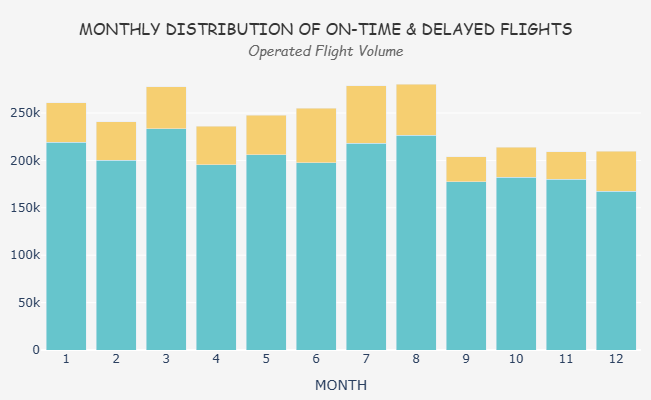

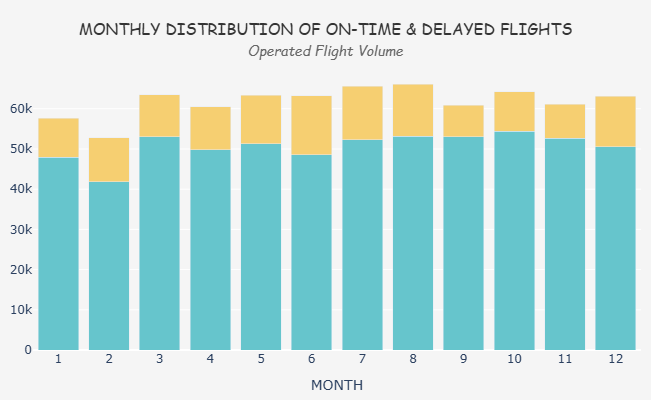

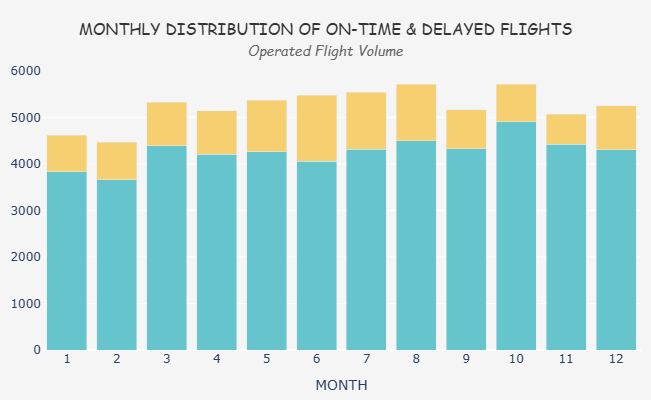

In [23]:
monthly_ontime_delay(df_flights)
monthly_ontime_delay(df_flights, year = 2019)
monthly_ontime_delay(df_flights, year = 2019, airline = "United Air Lines Inc.")

### Chart: MONTHLY FLIGHT VOLUME VS AVERAGE DELAY

In [37]:
def monthly_volume_delay(df, year = None, airline = None):
    if year is not None:
        df = filter_by_year(df, year)
        
    if airline is not None:
        df = filter_by_airline(df, airline)

    df_monthly_perf = (
        ontime_delay_by(df, ["MONTH"])
        .select(["MONTH", "n_operated", "avg_delay"]).to_pandas()
    )

    df_monthly_perf["text"] = df_monthly_perf["n_operated"].apply(format_compact)
    df_monthly_perf["avg_delay"] = df_monthly_perf["avg_delay"].round(1)

    fig = go.Figure()

    # Bar: number of flights
    fig.add_bar(
        x=df_monthly_perf["MONTH"], y=df_monthly_perf["n_operated"],
        name="Number of Flights", yaxis="y",
        text=df_monthly_perf["text"], textposition="outside", opacity=0.65,    
        hovertemplate=(
            "<b>Month:</b> %{x}<br>"
            "<b>Flights:</b> %{y:,}<br>"
            "<extra></extra>"
        ),
        marker=dict(color="#D97706"),
    )
    
    # Line: average delay
    fig.add_trace(
        go.Scatter(
            x=df_monthly_perf["MONTH"], y=df_monthly_perf["avg_delay"],
            name="Avg Departure Delay (min)",
            mode="lines+markers",
            yaxis="y2", 
            line=dict(
                color="#2563EB",
                width=2, dash="dash"   # 👈 nét đứt
            ),
            marker=dict(size=8),
        )
    )
    
    fig.update_layout(
        xaxis = dict(type="category", showgrid=False),
        yaxis = dict(title="Number of Flights", showgrid=False),
        yaxis2 = dict(title="Avg Delay (minutes)", 
                      overlaying="y", side="right", showgrid=False), 
        showlegend = False,
        title=dict(
            text=("MONTHLY FLIGHT VOLUME VS AVERAGE DELAY"),
            x=0.5, xanchor="center"
        ),
        margin = dict(l=10, r=10, t=70, b=10),
                      paper_bgcolor="#f5f5f5",   # nền toàn figure (kể cả title)
                      plot_bgcolor="#f5f5f5",    # nền vùng bar chart
                      title_font=dict(size=16, color="#333", family="Comic Sans MS")
    )
    fig.update_traces(cliponaxis=False)
    fig.show()

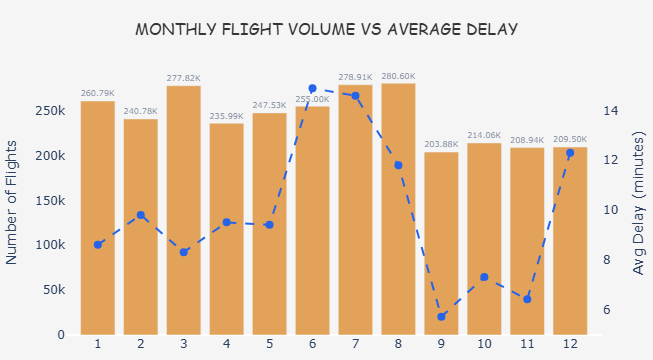

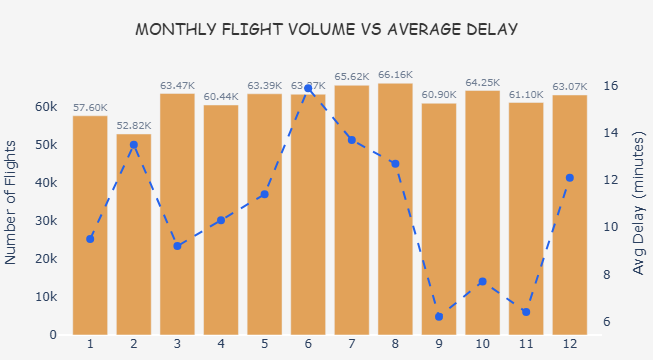

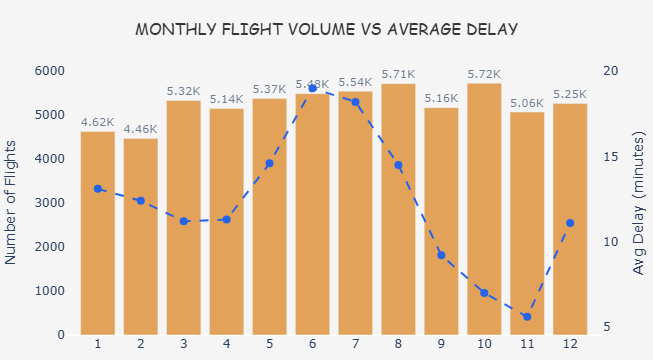

In [36]:
monthly_volume_delay(df_flights)
monthly_volume_delay(df_flights, year = 2019)
monthly_volume_delay(df_flights, year = 2019, airline = "United Air Lines Inc.")

### Chart: Delay Causes

In [44]:
def delay_causes(df, year = None, airline = None):
    if year is not None:
        df = filter_by_year(df, year)
        
    if airline is not None:
        df = filter_by_airline(df, airline)
        
    delay_cols = [
        "DELAY_DUE_CARRIER",
        "DELAY_DUE_WEATHER",
        "DELAY_DUE_NAS",
        "DELAY_DUE_SECURITY",
        "DELAY_DUE_LATE_AIRCRAFT"
    ]
    
    cause_map = {
        "DELAY_DUE_LATE_AIRCRAFT": "Late Aircraft",
        "DELAY_DUE_NAS": "NAS",
        "DELAY_DUE_CARRIER": "Carrier",
        "DELAY_DUE_WEATHER": "Weather",
        "DELAY_DUE_SECURITY": "Security"
    }
    
    df_delay_causes = (
        df
        .select(delay_cols).sum()
        .transpose(include_header=True)
        .rename({"column": "cause", "column_0": "delay_minutes"})
        .with_columns([
            (pl.col("delay_minutes") / pl.col("delay_minutes").sum() * 100).alias("pct"),
            pl.col("cause").replace(cause_map).alias("label")
        ])
        .with_columns(
            pl.col("pct").round(0).cast(pl.Int64).alias("n_blocks")
        )
    )
    
    # Fix rounding để tổng = 100
    diff = 100 - df_delay_causes["n_blocks"].sum()
    if diff != 0:
        idx = df_delay_causes["n_blocks"].arg_max()
        df_delay_causes = df_delay_causes.with_row_index("_i")
        df_delay_causes = df_delay_causes.with_columns(
            pl.when(pl.col("_i") == idx)
              .then(pl.col("n_blocks") + diff)
              .otherwise(pl.col("n_blocks"))
              .alias("n_blocks")
        ).drop("_i")
    
    df_delay_causes_pd = df_delay_causes.sort("pct", descending=True).to_pandas()

    labels = df_delay_causes_pd["label"].tolist()
    blocks = df_delay_causes_pd["n_blocks"].tolist()
    
    waffle = []
    for label, n in zip(labels, blocks):
        waffle.extend([label] * n)
    
    rows, cols = 5, 20
    x = np.tile(np.arange(cols), rows)
    y = np.repeat(np.arange(rows)[::-1], cols)

    color_map = {
    "Late Aircraft": "#FDBA74",  # pastel orange
    "NAS": "#93C5FD",            # pastel blue
    "Carrier": "#86EFAC",        # pastel green
    "Weather": "#FCA5A5",        # pastel red
    "Security": "#D1D5DB"        # pastel gray
    }

    fig = go.Figure()
    
    for cause, color in color_map.items():
        mask = np.array([c == cause for c in waffle])
    
        pct = df_delay_causes_pd.loc[
            df_delay_causes_pd["label"] == cause, "pct"
        ].values[0]
    
        minutes = df_delay_causes_pd.loc[
            df_delay_causes_pd["label"] == cause, "delay_minutes"
        ].values[0]
    
        fig.add_trace(
            go.Scatter(
                x = x[mask], y = y[mask],
                mode="markers",
                name=cause,
                marker=dict(
                    size=22, symbol = "square",
                    color=color, line = dict(width=1, color="#f5f5f5")
                ),
                hovertemplate=(
                    f"<b>{cause}</b><br>"
                    f"{pct:.1f}% of total delay<br>"
                    f"{minutes:,.0f} minutes"
                    "<extra></extra>"
                )
            )
        )
    
    fig.update_layout(
        title=dict(
            text=(
                "Flight Delay Breakdown by Causes"
                "<br><span style='font-size:14px;color:#666;font-style:italic'>"
                "Share of Total Delay Minutes"
                "</span>"
            ),
            x=0.5, xanchor="center"
        ),
    
        legend=dict(
            orientation="h",
            yanchor = "top", y = 1.2,
            xanchor = "center", x = 0.5,
            font=dict(size=12), title=None
        ),
    
        height=320,
        margin=dict(l=20, r=20, t=140, b=20),
    
        xaxis=dict(visible=False, range=[-0.5, 19.5]),
        yaxis=dict(visible=False, range=[-0.5, 4.5]),
    
        paper_bgcolor="#f5f5f5",
        plot_bgcolor="#f5f5f5",
        showlegend=True
    )
    
    fig.show()

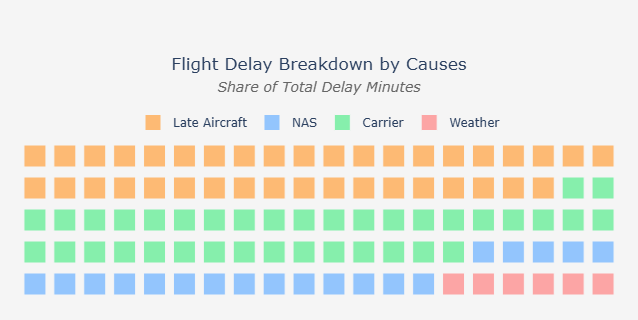

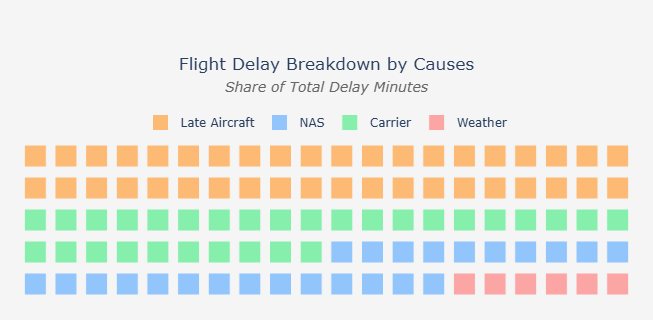

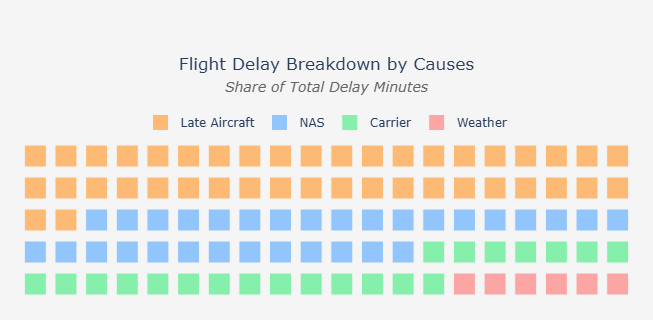

In [45]:
delay_causes(df_flights)
delay_causes(df_flights, year = 2019)
delay_causes(df_flights, year = 2019, airline = "United Air Lines Inc.")

## 3.2.2 Local Patterns + With/Without Filter